# Loading summary statistics of surrounding data

In [1]:
# Loading the necessary libraries
import os

os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Select Bank
ib = 9

In [ ]:
# Change to your directory which has the data files
dire = "/Users/jayw/Downloads/"

In [4]:
# Load Candidate and Injection Data 

with open(data_dir + f'/Cands_bank_{ib}.pkl', 'rb') as f:
    sum_stats_dets = pickle.load(f)

with open(data_dir + f'/inds_sorted_{ib}.pkl', 'rb') as f:
    inds_sorted = pickle.load(f)

with open(data_dir + f'/Times_cands_{ib}.pkl', 'rb') as f:
    times_cands_dets = pickle.load(f)

t_inj_raw = np.load(data_dir + f'/Inj_times_O3b.npy') # Load raw injection times (randomly drawn between start and end of the run)

In [5]:
# === Identify Coincident Injections ===

coincident_injs = []
total_rank_obj_cands = len(np.concatenate(inds_sorted))

for i in range(len(sum_stats_dets[0])):
    stats_H, stats_L = sum_stats_dets[0][i], sum_stats_dets[1][i]
    if stats_H is not None and stats_L is not None:
        if i < total_rank_obj_cands:
            coincident_injs.append(i)
        elif (
            np.all(np.array([stats_H[1], stats_L[1]]) > 0) and
            np.all(np.array([stats_H[3], stats_L[3]]) > 0.5)
        ):
            coincident_injs.append(i)
    elif i < total_rank_obj_cands:
        print(f"Missing stats at index {i}")
        raise RuntimeError("Unexpected None entry in ranked candidate stats")

# Append extra injections (beyond ranking) to inds_sorted
extra_inds = np.array(coincident_injs[total_rank_obj_cands:]) - total_rank_obj_cands
inds_sorted.append(extra_inds)
print(f"Number of coincident injections: {len(extra_inds)}")

Number of coincident injections: 31806


In [6]:
# === Append Times for Extra Injections ===

t_extra_inj = t_inj_raw[inds_sorted[-1]]
times_cands_dets[0].append(t_extra_inj)
times_cands_dets[1].append(t_extra_inj)

In [7]:
sum_stats_dets = [
    [sum_stats_dets[ifo][i] for i in coincident_injs]
    for ifo in range(2)
]


In [8]:
# === Determine Trigger List Dimension ===

for sample in sum_stats_dets[0]:
    if sample[4] is not None:
        triglist_dim = sample[4].shape[-1]
        break

print("triglist_dim is", triglist_dim)


triglist_dim is 5


In [9]:
# === Helper Function: Pad Trigger Lists for uniform length ===

def triglist_pad_fn(triglist, length=3, triglist_dim=4):
    """Pads trigger lists to a uniform length, sorted by descending SNR (column 1)."""
    triglist_pad = []
    n_elements = []
    for t in triglist:
        if t is not None:
            n_elements.append(len(t))
            top_t = t[np.argsort(t[:, 1])[::-1][:length]]  # top by SNR
            if len(top_t) < length:
                top_t = np.vstack([top_t, np.zeros((length - len(top_t), triglist_dim))])
            triglist_pad.append(top_t)
        else:
            n_elements.append(0)
            triglist_pad.append(np.zeros((length, triglist_dim)))
    return np.array(n_elements), np.array(triglist_pad)


In [10]:
# === Process All Candidate Sets ===

be_mask, t_closest_hole, normfac, pdrift = [], [], [], []
n_trig, triglist_H, triglist_L, triglist_pad = [], [], [], []

pad_length = 3
index = 0  # global index over sum_stats_dets

for i_cand in range(6):
    # Initialize containers for this candidate set
    be_mask_cand, t_closest_cand = [], []
    normfac_cand, pdrift_cand = [], []
    triglist_H_cand, triglist_L_cand = [], []

    if len(inds_sorted[i_cand]) > 0:
        for _ in range(len(inds_sorted[i_cand])):
            stats_H, stats_L = sum_stats_dets[0][index], sum_stats_dets[1][index]
            be_mask_cand.append([stats_H[0], stats_L[0]])
            t_closest_cand.append([stats_H[1], stats_L[1]])
            normfac_cand.append([stats_H[2], stats_L[2]])
            pdrift_cand.append([stats_H[3], stats_L[3]])
            triglist_H_cand.append(stats_H[4])
            triglist_L_cand.append(stats_L[4])
            index += 1

        # Convert to arrays
        be_mask_cand = np.array(be_mask_cand)
        t_closest_cand = np.array(t_closest_cand)
        normfac_cand = np.array(normfac_cand)
        pdrift_cand = np.array(pdrift_cand)

        # Clip values for safety
        if np.any(t_closest_cand <= -1):
            count = np.sum(t_closest_cand <= -1)
            print(f'For i_cand {i_cand}: {count} entries with t_closest_hole <= -1')
            t_closest_cand[t_closest_cand <= -1] = -1

        if np.any(pdrift_cand <= 0.4):
            count = np.sum(pdrift_cand <= 0.4)
            print(f'For i_cand {i_cand}: {count} entries with pdrift <= 0.4')
            pdrift_cand[pdrift_cand <= 0.4] = 0.4

        # Pad trigger lists
        n_trig_cand = np.zeros((2, len(be_mask_cand)))
        triglist_cand = np.zeros((2, len(be_mask_cand), pad_length, triglist_dim))
        n_trig_cand[0], triglist_cand[0] = triglist_pad_fn(triglist_H_cand, pad_length, triglist_dim)
        n_trig_cand[1], triglist_cand[1] = triglist_pad_fn(triglist_L_cand, pad_length, triglist_dim)
    else:
        # Empty candidate list
        n_trig_cand = []
        triglist_cand = []

    # Append to global lists
    be_mask.append(be_mask_cand)
    t_closest_hole.append(t_closest_cand)
    normfac.append(normfac_cand)
    pdrift.append(pdrift_cand)
    n_trig.append(n_trig_cand)
    triglist_H.append(triglist_H_cand)
    triglist_L.append(triglist_L_cand)
    triglist_pad.append(triglist_cand)


For i_cand 0: 22 entries with t_closest_hole <= -1
For i_cand 1: 1 entries with t_closest_hole <= -1
For i_cand 3: 1 entries with t_closest_hole <= -1
For i_cand 4: 2 entries with t_closest_hole <= -1


In [11]:
print(f"Number of Candidates : {len(be_mask[0])}")
print(f"Number of Glitches : {len(be_mask[-1])}")

Number of Candidates : 20000
Number of Glitches : 31806


### Training RF with only nonlocal info

In [12]:
# === Construct Feature Inputs for Each Detector (H1 = 0, L1 = 1) ===

inputs_cands_dets = []
for ind_det in range(2):
    inputs_cands = []
    for cand_type in range(6):
        if len(be_mask[cand_type]) == 0:
            inputs_cand = []
        else:
            inputs_cand = np.c_[
                be_mask[cand_type][:, ind_det].astype(float),
                t_closest_hole[cand_type][:, ind_det].astype(float),
                normfac[cand_type][:, ind_det].astype(float),
                pdrift[cand_type][:, ind_det].astype(float),
                n_trig[cand_type][ind_det].astype(float),
                triglist_pad[cand_type][ind_det].reshape(-1, pad_length * triglist_dim).astype(float)
            ]
        inputs_cands.append(inputs_cand)
    inputs_cands_dets.append(inputs_cands)

In [13]:
# === Create Train/Test Split Indices and avoiding "double counting" of nearby times ===

train_iters = 4
train_test_inds_cands = []

for i_det in range(2):
    train_test_ind = []
    for i_cand in range(6):
        times = times_cands_dets[i_det][i_cand]
        if len(times) == 0:
            train_test_ind.append([])
        else:
            train_test_ind.append((times // 400 % train_iters).astype(int))
    train_test_inds_cands.append(train_test_ind)

In [14]:
# === Prepare Input Data for ML (Used in Both Detectors) ===

def input_data_ML(ind_det=0):
    inputs_train = np.r_[
        inputs_cands_dets[ind_det][0],  # background
        inputs_cands_dets[ind_det][-1]  # injections
    ]
    labels = np.concatenate([
        np.zeros(len(be_mask[0])),      # background = 0
        np.ones(len(be_mask[-1]))       # injections = 1
    ])
    weights = np.ones_like(labels)
    weights[labels > 0] *= (np.count_nonzero(labels == 0) / np.count_nonzero(labels == 1))

    train_test_inds = np.r_[
        train_test_inds_cands[ind_det][0],
        train_test_inds_cands[ind_det][-1]
    ]
    return inputs_train, labels, weights, train_test_inds


In [15]:
# === Train Random Forest and Evaluate Log-Probabilities ===

i_test = 0  # fold index for cross-validation

def log_prob_det(ind_det):
    inputs_train, labels, weights, train_test_inds = input_data_ML(ind_det)

    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=100,
        criterion='gini',
        random_state=42,
        n_jobs=5
    )
    # Train on training set only
    rf.fit(
        inputs_train[train_test_inds != i_test],
        labels[train_test_inds != i_test],
        sample_weight=weights[train_test_inds != i_test]
    )

    # Predict log-probabilities on the held-out fold
    probs_valid = 2 * np.log(rf.predict_proba(inputs_train[train_test_inds == i_test])[:, 1])
    probs_valid = np.nan_to_num(probs_valid, neginf=-10)

    return probs_valid, labels[train_test_inds == i_test], rf.feature_importances_

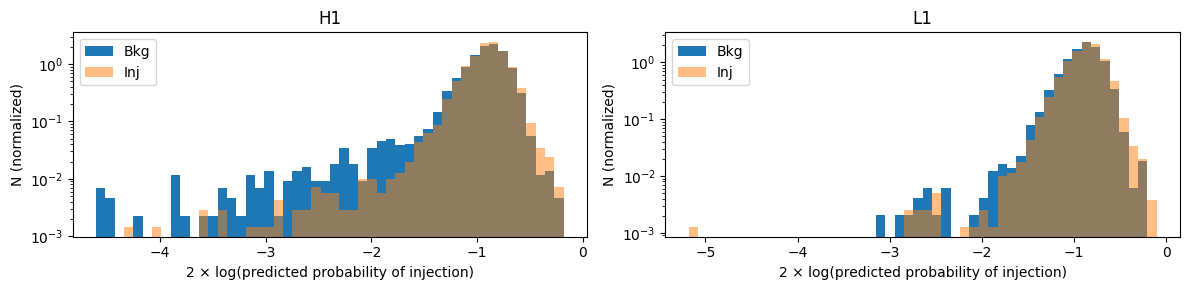

In [16]:
# === Plot Log-Probability Histograms for H1 and L1 ===

plt.figure(figsize=(12, 3))
log_scale = True

for i_det, det_name in zip([0, 1], ['H1', 'L1']):
    plt.subplot(1, 2, i_det + 1)

    probs_RF, labels, feat_importance = log_prob_det(i_det)
    bins = np.histogram(probs_RF, bins=50)[1]

    mask_inj = labels.astype(bool)

    plt.hist(probs_RF[~mask_inj], bins=bins, label='Bkg', density=True, log=log_scale)
    plt.hist(probs_RF[mask_inj], bins=bins, label='Inj', density=True, alpha=0.5, log=log_scale)

    plt.title(det_name)
    plt.xlabel('2 × log(predicted probability of injection)')
    plt.ylabel('N (normalized)')
    plt.legend()

plt.tight_layout()
plt.show()

### Training a simple MLP to see if I can replicate RF results

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time


In [18]:

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0) if device == 'cuda' else 'Using CPU')


NVIDIA A100-PCIE-40GB


In [19]:

# Function to build MLP
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.ReLU()):
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)


In [20]:
features = np.r_[inputs_cands_dets[i_det][0], inputs_cands_dets[i_det][-1]]
labels = np.concatenate((np.zeros(len(be_mask[0])), np.ones(len(be_mask[-1]))))
weights = np.ones_like(labels)
weights[labels>0] *= np.count_nonzero(labels==0)/np.count_nonzero(labels>0)

features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)
weights = torch.FloatTensor(weights).to(device)

In [22]:

# Move to tensors (avoid double conversion)
def to_tensor_on_device(x, device):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    return torch.as_tensor(x, dtype=torch.float32, device=device)

features = to_tensor_on_device(features, device)
labels = to_tensor_on_device(labels, device)
weights = to_tensor_on_device(weights, device)

# Focal Loss implementation (gamma=0 means BCE)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, labels):
        bce_loss = self.bce(logits, labels)
        probs = torch.sigmoid(logits)
        pt = probs * labels + (1 - probs) * (1 - labels)
        focal_factor = (1 - pt) ** self.gamma
        return focal_factor * bce_loss  # No reduction


In [23]:

# NRE definition
class NeuralRatioEstimator(nn.Module):
    def __init__(self, in_dim=20, layers=8):
        super().__init__()
        self.classifier = build_mlp(in_dim, hidden_dim=16, output_dim=1, layers=layers)
        self.loss_fn = FocalLoss(gamma=0.0)  # Set gamma > 0 for focal loss

    def forward(self, x):
        return self.classifier(x)
    
    def loss(self, x, labels, weights):
        logits = self(x).squeeze()
        return (self.loss_fn(logits, labels) * weights).mean()


In [24]:

# Model setup
batch_size = 10000
layers_classifier = 6
nre = NeuralRatioEstimator(in_dim=features.shape[1], layers=layers_classifier).to(device)
nre.val_loss_min = float('inf')
val_losses = []
optimizer = optim.Adam(nre.parameters(), lr=4e-4, weight_decay=1e-9)


In [25]:

# ⚠️ You must define `train_test_inds_cands` and `ind_det` before running
det = 0
i_test = 0
train_test_inds = np.r_[train_test_inds_cands[ind_det][0], train_test_inds_cands[ind_det][-1]]
mask_train = (train_test_inds != i_test)


In [26]:

# Split features, labels, weights
features_train = features[mask_train]
labels_train = labels[mask_train]
weights_train = weights[mask_train]
n_samples_train = len(features_train)


In [30]:

# Training loop
print("Starting training...")
start_time = time.time()
for epoch in range(1000):
    nre.train()
    ind = torch.randperm(n_samples_train).to(device)

    for i in range(0, n_samples_train, batch_size):
        # Batch slicing
        features_in = features_train[ind][i:i+batch_size]
        labels_in = labels_train[ind][i:i+batch_size]
        weights_in = weights_train[ind][i:i+batch_size]

        optimizer.zero_grad()
        loss = nre.loss(features_in, labels_in, weights_in)
        loss.backward()
        optimizer.step()

    # Validation every 20 epochs
    if epoch % 20 == 0:
        nre.eval()
        with torch.no_grad():
            val_loss = nre.loss(features[~mask_train], labels[~mask_train], weights[~mask_train]).item()
            val_losses.append(val_loss)

            # Save best model
            if val_loss < nre.val_loss_min:
                nre.val_loss_min = val_loss
                torch.save(nre.state_dict(), f'NN_classifier_{i_test}_{det}.pt')

        print(f"Epoch {epoch+1}, train loss: {loss.item():.4f}, val loss: {val_loss:.4f}")

print(f"Training completed in {time.time() - start_time:.1f}s")


Starting training...
Epoch 1, train loss: 0.5260, val loss: 0.5374
Epoch 21, train loss: 0.5272, val loss: 0.5372


Epoch 41, train loss: 0.5248, val loss: 0.5375
Epoch 61, train loss: 0.5235, val loss: 0.5377
Epoch 81, train loss: 0.5269, val loss: 0.5382
Epoch 101, train loss: 0.5275, val loss: 0.5380
Epoch 121, train loss: 0.5272, val loss: 0.5382
Epoch 141, train loss: 0.5261, val loss: 0.5382
Epoch 161, train loss: 0.5281, val loss: 0.5384
Epoch 181, train loss: 0.5250, val loss: 0.5387
Epoch 201, train loss: 0.5262, val loss: 0.5389
Epoch 221, train loss: 0.5275, val loss: 0.5388
Epoch 241, train loss: 0.5259, val loss: 0.5392
Epoch 261, train loss: 0.5262, val loss: 0.5392
Epoch 281, train loss: 0.5242, val loss: 0.5395
Epoch 301, train loss: 0.5258, val loss: 0.5400
Epoch 321, train loss: 0.5244, val loss: 0.5401
Epoch 341, train loss: 0.5245, val loss: 0.5402
Epoch 361, train loss: 0.5259, val loss: 0.5402
Epoch 381, train loss: 0.5241, val loss: 0.5404
Epoch 401, train loss: 0.5246, val loss: 0.5407
Epoch 421, train loss: 0.5222, val loss: 0.5409
Epoch 441, train loss: 0.5255, val loss: 0.

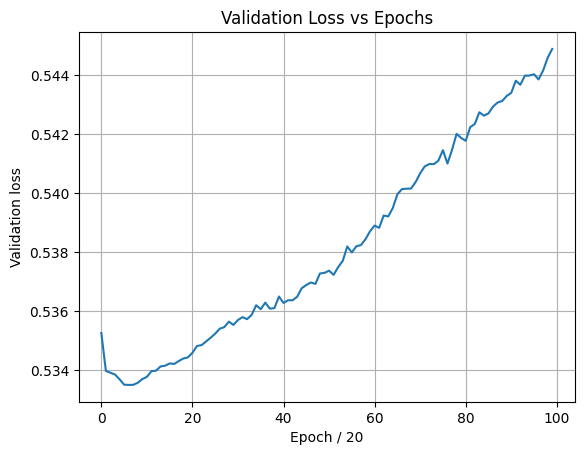

In [31]:

# Plot validation loss
plt.figure()
plt.plot(val_losses)
plt.xlabel('Epoch / 20'); plt.ylabel('Validation loss')
plt.title('Validation Loss vs Epochs')
plt.grid()


In [32]:

# Reload best model and evaluate
nre.load_state_dict(torch.load(f'   {i_test}_{det}.pt'))
nre.eval()


FileNotFoundError: [Errno 2] No such file or directory: '   0_0.pt'

In [33]:

# Histogram of classifier scores
true_mask = labels[~mask_train].cpu().numpy().astype(bool)
with torch.no_grad():
    logits = nre(features[~mask_train]).squeeze().cpu().numpy()
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    log_scores = 2 * np.log(probs)


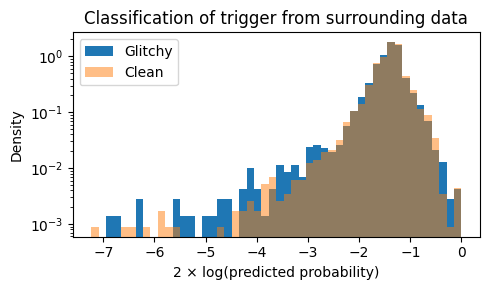

In [34]:

# Plot histogram
log = True
plt.figure(figsize=(5, 3))
bins = np.histogram(log_scores, bins=50)[1]
plt.hist(log_scores[~true_mask], bins=bins, label='Glitchy', density=True, log=log)
plt.hist(log_scores[true_mask], bins=bins, label='Clean', density=True, alpha=0.5, log=log)
plt.legend(); plt.title('Classification of trigger from surrounding data')
plt.xlabel('2 × log(predicted probability)'); plt.ylabel('Density')
plt.tight_layout()
plt.show()


## Training deepset network

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time


In [32]:

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {torch.cuda.get_device_name(0) if device=="cuda" else "CPU"}')


Using device: NVIDIA A100-PCIE-40GB


In [33]:

# Reuse from previous code
def build_mlp(input_dim, hidden_dim, output_dim, layers, activation=nn.GELU()):
    seq = [nn.Linear(input_dim, hidden_dim), activation]
    for _ in range(layers):
        seq += [nn.Linear(hidden_dim, hidden_dim), activation]
    seq += [nn.Linear(hidden_dim, output_dim)]
    return nn.Sequential(*seq)


In [34]:

# Constants and configuration
empty_embedding = nn.Parameter(torch.zeros((1, triglist_dim)).to(device))
det_ind = 0  # Change to 1 for L1
det = 'H' if det_ind == 0 else 'L'


In [35]:

# Build glitch_dataset for the detector
glitch_dataset = (triglist_H[0] + triglist_H[-1]).copy() if det_ind == 0 else (triglist_L[0] + triglist_L[-1]).copy()
for i in range(len(glitch_dataset)):
    if glitch_dataset[i] is None:
        glitch_dataset[i] = empty_embedding
    else:
        glitch_dataset[i] = torch.FloatTensor(glitch_dataset[i]).to(device)


In [36]:
# Load features, labels, weights, train/test split
features, labels, weights, train_test_inds = input_data_ML(det_ind)
features = features[:, :4]  # First 4 features
features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)
weights = torch.FloatTensor(weights).to(device)

i_test = 0
mask_train = (train_test_inds != i_test)
features_train = features[mask_train]
labels_train = labels[mask_train]
weights_train = weights[mask_train]
glitches_train = [glitch_dataset[i] for i in np.arange(len(train_test_inds))[mask_train]]
glitches_test = [glitch_dataset[i] for i in np.arange(len(train_test_inds))[~mask_train]]

n_samples_train = len(features_train)


In [37]:

# Neural Ratio Estimator Definition
class NeuralRatioEstimator(nn.Module):
    def __init__(self, in_dim=7, layers_classifier=4, layers_deepset=4, dout_deepset=8):
        super().__init__()
        self.classifier = build_mlp(in_dim, 16, 1, layers_classifier)
        self.glitch_deepset = build_mlp(triglist_dim, 16, dout_deepset, layers_deepset)

    def forward(self, glitches_arr):
        ind_array = [len(g) for g in glitches_arr]
        ind_array = torch.IntTensor(np.cumsum(ind_array)).to(device)
        ind_array = torch.cat((torch.zeros(1, dtype=torch.int32, device=device), ind_array))
        ds_out = self.glitch_deepset(torch.cat(glitches_arr))
        ds_sum = [torch.sum(ds_out[ind_array[i]:ind_array[i+1]], dim=0) for i in range(len(glitches_arr))]
        return torch.stack(ds_sum)

    def loss(self, features, glitches, labels, weights):
        ds_out = self(glitches)
        logits = self.classifier(torch.cat((features, ds_out), dim=1)).squeeze()
        probs = torch.sigmoid(logits)
        return nn.BCELoss(reduction='none')(probs, labels) * weights


In [38]:
# Instantiate model
batch_size = 10000
nre = NeuralRatioEstimator(in_dim=features.shape[1] + 8, layers_classifier=6, layers_deepset=4, dout_deepset=8).to(device)
nre.val_loss_min = 1e10
optimizer = optim.Adam(nre.parameters(), lr=1e-2)
val_losses = []
epochs = 100

# Train loop
print("Starting training...")
start_time = time.time()
for epoch in range(epochs):
    ind = torch.randperm(n_samples_train).to(device)
    glitches_perm = [glitches_train[i] for i in ind]
    nre.train()

    for i in range(0, len(ind), batch_size):
        features_in = features_train[ind][i:i+batch_size]
        glitches_in = glitches_perm[i:i+batch_size]
        labels_in = labels_train[ind][i:i+batch_size]
        weights_in = weights_train[ind][i:i+batch_size]

        optimizer.zero_grad()
        loss = nre.loss(features_in, glitches_in, labels_in, weights_in).mean()
        loss.backward()
        optimizer.step()

    if epoch % 2 == 0:
        nre.eval()
        with torch.no_grad():
            val_loss = nre.loss(
                features[~mask_train],
                glitches_test,
                labels[~mask_train],
                weights[~mask_train]
            ).mean().item()
            val_losses.append(val_loss)

            if val_loss < nre.val_loss_min:
                nre.val_loss_min = val_loss
                torch.save(nre.state_dict(), f'NN_classifier_{det}.pt')

        print(f"Epoch {epoch+1}, train loss: {loss.item():.4f}, val loss: {val_loss:.4f}")
print(f"Training completed in {time.time() - start_time:.1f}s")


Starting training...


Epoch 1, train loss: 0.5349, val loss: 0.5347
Epoch 3, train loss: 0.5351, val loss: 0.5345
Epoch 5, train loss: 0.5343, val loss: 0.5340
Epoch 7, train loss: 0.5324, val loss: 0.5326
Epoch 9, train loss: 0.5312, val loss: 0.5340
Epoch 11, train loss: 0.5352, val loss: 0.5345
Epoch 13, train loss: 0.5349, val loss: 0.5345
Epoch 15, train loss: 0.5360, val loss: 0.5345
Epoch 17, train loss: 0.5349, val loss: 0.5345
Epoch 19, train loss: 0.5359, val loss: 0.5341
Epoch 21, train loss: 0.5345, val loss: 0.5329
Epoch 23, train loss: 0.5332, val loss: 0.5321


KeyboardInterrupt: 

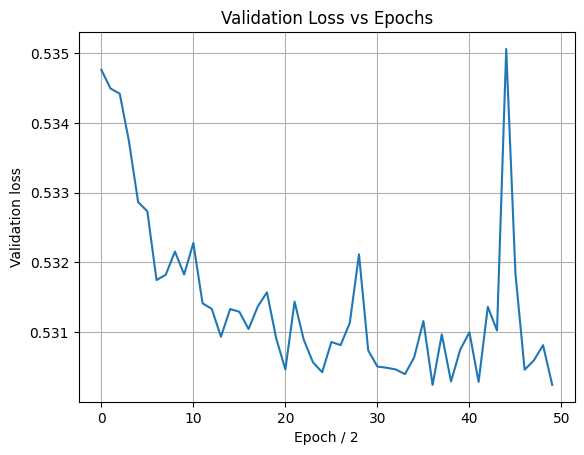

In [ ]:
# Plot validation loss curve
plt.figure()
plt.plot(val_losses)
plt.xlabel('Epoch / 2'); plt.ylabel('Validation loss'); plt.title('Validation Loss vs Epochs')
plt.grid()


In [ ]:
# Reload best model and evaluate
nre.load_state_dict(torch.load(f'NN_classifier_{det}.pt'))
nre.eval()
with torch.no_grad():
    ds_val = nre(glitches_test)
    logits = nre.classifier(torch.cat((features[~mask_train], ds_val), dim=1)).squeeze()
    true_mask = labels[~mask_train].bool()


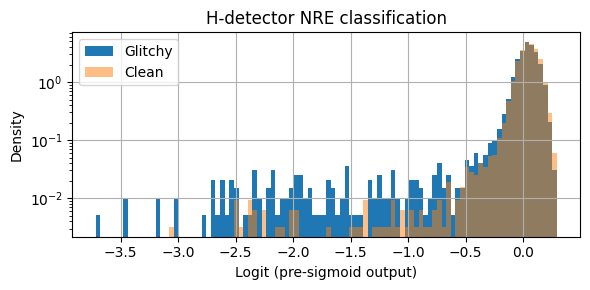

In [ ]:

# Plot histogram of logits
log = True
plt.figure(figsize=(6, 3))
bins = np.histogram(logits.cpu().numpy(), bins=100)[1]
plt.hist(logits[~true_mask].cpu().numpy(), bins=bins, label='Glitchy', density=True, log=log)
plt.hist(logits[true_mask].cpu().numpy(), bins=bins, label='Clean', density=True, alpha=0.5, log=log)
plt.legend(); plt.title(f'{det}-detector NRE classification')
plt.xlabel('Logit (pre-sigmoid output)'); plt.ylabel('Density'); plt.grid(True)
plt.tight_layout()
plt.show()
